In [1]:
import pandas as pd
import geopandas as gpd
import requests
import shapely
import json
import matplotlib.pyplot as plt

#from ardac_utils import *

In [2]:
from ardac_utils import *

In [5]:
fz_gdf = get_area_gdf_by_category("fire_zones", 3338)
fz_data = get

<Axes: >

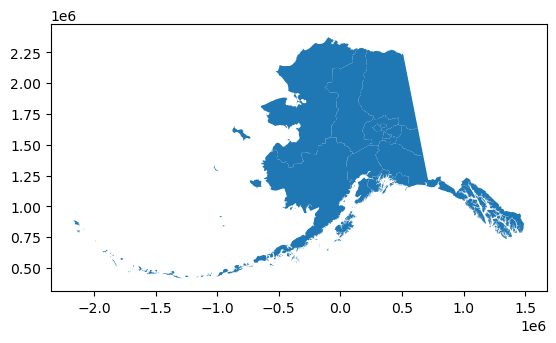

In [6]:
fz_gdf.plot()

In [3]:
#get fire mgmt zone IDs from SNAP Data API
#write the attributes to a dataframe
with requests.Session() as s:
    response = s.get('https://earthmaps.io/places/fire_zones')
    fz_names_json = response.json()

In [4]:
#check out the json structure
fz_names_json[0]

{'id': 'FIRE1', 'name': 'Anchorage/Mat-Su Area', 'type': 'fire_zone'}

In [7]:
fz_names_json

[{'id': 'FIRE1', 'name': 'Anchorage/Mat-Su Area', 'type': 'fire_zone'},
 {'id': 'FIRE2', 'name': 'Chugach National Forest', 'type': 'fire_zone'},
 {'id': 'FIRE3', 'name': 'Copper River Area', 'type': 'fire_zone'},
 {'id': 'FIRE4', 'name': 'Delta Area', 'type': 'fire_zone'},
 {'id': 'FIRE5', 'name': 'Fairbanks Area', 'type': 'fire_zone'},
 {'id': 'FIRE6', 'name': 'Galena Zone', 'type': 'fire_zone'},
 {'id': 'FIRE7', 'name': 'Haines Area', 'type': 'fire_zone'},
 {'id': 'FIRE8', 'name': 'Kenai/Kodiak Area', 'type': 'fire_zone'},
 {'id': 'FIRE9', 'name': 'Military Zone', 'type': 'fire_zone'},
 {'id': 'FIRE10', 'name': 'Southwest Area', 'type': 'fire_zone'},
 {'id': 'FIRE11', 'name': 'Tanana Zone', 'type': 'fire_zone'},
 {'id': 'FIRE12', 'name': 'Tok Area', 'type': 'fire_zone'},
 {'id': 'FIRE13', 'name': 'Tongass National Forest', 'type': 'fire_zone'},
 {'id': 'FIRE14', 'name': 'Upper Yukon Zone', 'type': 'fire_zone'}]

In [5]:
#convert the json response to a dataframe
fz_df = pd.DataFrame(columns=["id", "fz_name"])

for fz in fz_names_json:
    new_row = {'id': fz['id'], 
               "fz_name" : fz['name']}
    fz_df.loc[len(fz_df)] = new_row

fz_df

,id,fz_name
0,FIRE1,Anchorage/Mat-Su Area
1,FIRE2,Chugach National Forest
2,FIRE3,Copper River Area
3,FIRE4,Delta Area
4,FIRE5,Fairbanks Area
5,FIRE6,Galena Zone
6,FIRE7,Haines Area
7,FIRE8,Kenai/Kodiak Area
8,FIRE9,Military Zone
9,FIRE10,Southwest Area


In [24]:
#using the fire zone IDs, get boundaries as GeoJSON string from SNAP Data API
#add a check for error codes in the response
#then get ALFRESCO flammability data from SNAP Data API
#convert to geodataframes, then concatenate them all into one geodataframe

fz_gdfs = []

for index, row in fz_df.iterrows():
    with requests.Session() as s:
        response1 = s.get(str('https://earthmaps.io/boundary/area/' + str(row.id)))
        if response1.status_code != 200:
                print("no fire zone polygon data for " + row.fz_name)
        else:
            geojson = response1.json()
            geojson['the_geom'] = shapely.from_geojson(json.dumps(geojson))
            gdf = gpd.GeoDataFrame([geojson]).set_geometry('the_geom').set_crs(4326)
            gdf.drop(columns=['geometry', 'properties', 'type'], inplace=True)
            gdf['id'] = row.id

        gdf['flammability_2010-2039'] = None
        gdf['flammability_2040-2069'] = None
        gdf['flammability_2070-2099'] = None

        response2 = s.get(str('https://earthmaps.io/alfresco/flammability/area/' + str(row.id)))
        if response2.status_code != 200:    
                print("no flammability data for " + row.fz_name)
        else:
            flam_json = response2.json()
            gdf.iloc[0, gdf.columns.get_loc('flammability_2010-2039')] = flam_json['2010-2039']['5modelAvg']['rcp60']
            gdf.iloc[0, gdf.columns.get_loc('flammability_2040-2069')] = flam_json['2040-2069']['5modelAvg']['rcp60']
            gdf.iloc[0, gdf.columns.get_loc('flammability_2070-2099')] = flam_json['2070-2099']['5modelAvg']['rcp60']

        fz_gdfs.append(gdf)

fz_gdf = pd.concat(fz_gdfs)
fz_gdf

no flammability data for Southwest Area


,id,the_geom,flammability_2010-2039,flammability_2040-2069,flammability_2070-2099
0,FIRE1,"MULTIPOLYGON (((-150.63438 61.28439, -150.6359...",0.0008,0.0016,0.0029
0,FIRE2,"MULTIPOLYGON (((-146.34172 59.40813, -146.3417...",0.0,0.0,0.0
0,FIRE3,"MULTIPOLYGON (((-146.60575 61.14989, -146.6060...",0.0022,0.0029,0.0026
0,FIRE4,"MULTIPOLYGON (((-145.74841 63.93855, -145.7476...",0.0019,0.0026,0.0035
0,FIRE5,"MULTIPOLYGON (((-144.12834 64.64817, -144.1464...",0.0029,0.0036,0.0048
0,FIRE6,"MULTIPOLYGON (((-168.82279 63.07621, -168.8244...",0.0037,0.003,0.0038
0,FIRE7,"MULTIPOLYGON (((-135.51564 59.31696, -135.5162...",0.0,0.0,0.0
0,FIRE8,"MULTIPOLYGON (((-155.79343 55.82351, -155.7932...",0.0028,0.0033,0.0029
0,FIRE9,"MULTIPOLYGON (((-145.78555 63.52497, -145.7845...",0.0044,0.0051,0.0057
0,FIRE10,"MULTIPOLYGON (((-173.15502 51.99866, -173.1563...",None,None,None


/home/UA/jdpaul3/mambaforge/envs/atmospheric_rivers/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/home/UA/jdpaul3/mambaforge/envs/atmospheric_rivers/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/home/UA/jdpaul3/mambaforge/envs/atmospheric_rivers/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


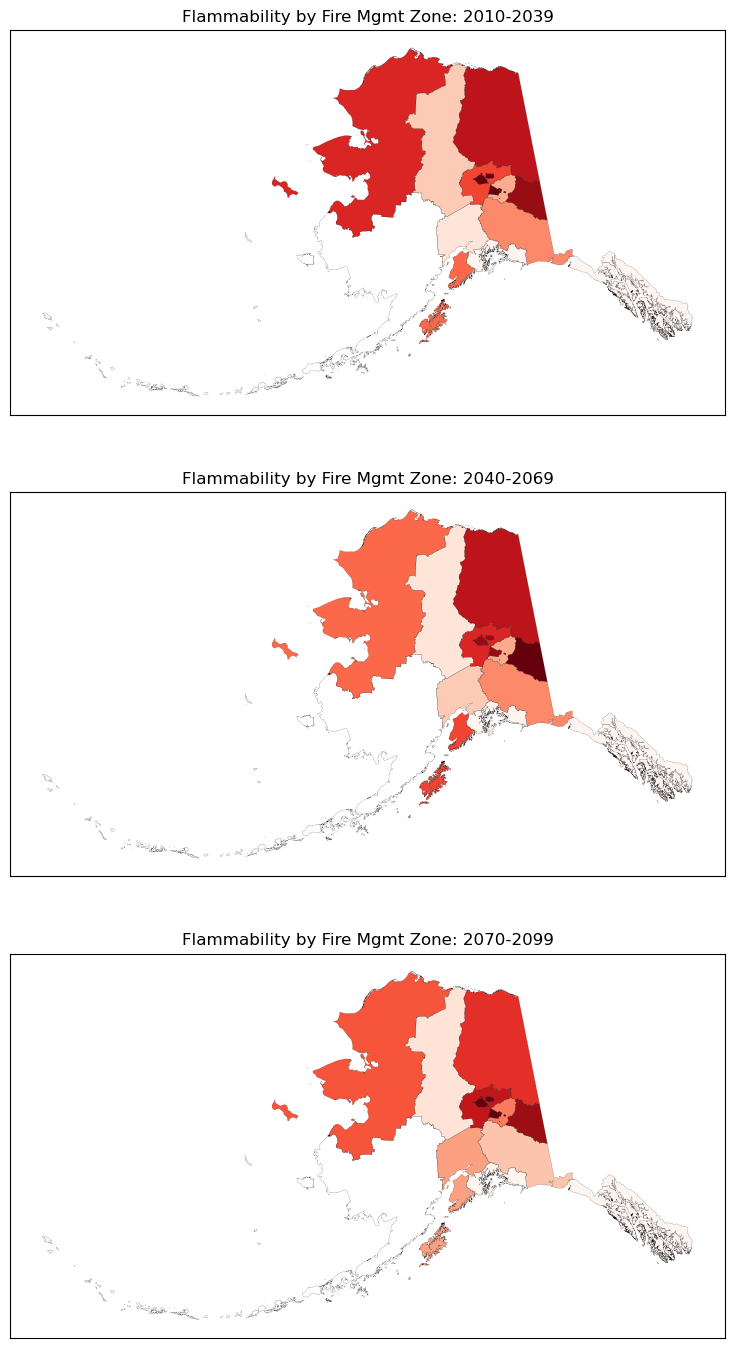

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,14))

fz_gdf.to_crs('epsg:3338').boundary.plot(color='black', linewidth=0.1, ax=ax1)
fz_gdf.to_crs('epsg:3338').plot(column='flammability_2010-2039', cmap='Reds', ax=ax1)

fz_gdf.to_crs('epsg:3338').boundary.plot(color='black', linewidth=0.1, ax=ax2)
fz_gdf.to_crs('epsg:3338').plot(column='flammability_2040-2069', cmap='Reds', ax=ax2)

fz_gdf.to_crs('epsg:3338').boundary.plot(color='black', linewidth=0.1, ax=ax3)
fz_gdf.to_crs('epsg:3338').plot(column='flammability_2070-2099', cmap='Reds', ax=ax3)

ax1.title.set_text('Flammability by Fire Mgmt Zone: 2010-2039')
ax2.title.set_text('Flammability by Fire Mgmt Zone: 2040-2069')
ax3.title.set_text('Flammability by Fire Mgmt Zone: 2070-2099')

fig.tight_layout()
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)